# Scrapping Text Data from NITT Website

In [ ]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin
from requests.exceptions import RequestException

import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
df1=pd.read_csv('Scraped_Data1.csv')
df2=pd.read_csv('Scraped_Data2.csv')
df=pd.concat([df1, df2], axis=0)
df.shape

In [ ]:
df_unique = df.drop_duplicates(subset='url', keep='first')
df_unique.shape

In [ ]:
with open("my_list.txt", "r", encoding="utf-8") as file:
    my_list = [line.strip() for line in file]

# Print the list
len(my_list)

In [ ]:
links = ['https://www.nitt.edu/']
visited = set()
text = dict()

links=my_list
visited = set(df['url'].values)
text = dict()
while len(links)>0:
    link = links.pop(0)
    
    if link in visited:
        continue
    
    visited.add(link)

    # Fetch the page for the url
    try:
        response = requests.get(link, verify=False, timeout=5)
        response.raise_for_status()
        print(f'{link} {len(text)} {len(links)}')
        soup = BeautifulSoup(response.text, 'html.parser')
        for url in soup.find_all('a', href=True):
            next_url=urljoin(link, url['href'])
            
            if next_url in visited:
                continue
            if 'www.nitt.edu' not in next_url:
                visited.add(next_url)
                continue
                
            if '+login' in next_url or '+search' in next_url or '+view' in next_url:
                visited.add(next_url)
                continue
            
            format_avoid=['pdf', 'jpg', 'peg', 'doc', 'ocx', 'png',\
                          '.dz', 'exe', 'php', 'zip', 'exe', 'rar']
            if next_url[-3:].lower() in format_avoid:
                visited.add(next_url)
                continue
            
            if next_url not in links and next_url not in visited:
                links.append(next_url)    
        
        side_div = soup.find('div', id='side')
    
        # Extract text content
        if side_div:
            curr_text=side_div.get_text()
            if len(curr_text)>50:
                text[link]=curr_text
    except Exception as e:
        pass

In [ ]:
temp = [link for link in links if "www.nitt.edu" in link]
len(temp)


In [ ]:
links=temp

In [ ]:
len(links)

In [ ]:
with open("my_list.txt", "w", encoding="utf-8") as file:
    for item in links:
        file.write(f"{item}\n")

In [ ]:
import pandas as pd
data = {
    "url": text.keys(),
    "text": text.values()
}
df = pd.DataFrame(data=data,
                  columns=["url", "text"])
df.shape

In [ ]:
import re

def split_camel_case(text):
    text = re.sub(r'[^\x20-\x7E]', '', text)
    text = re.sub(r'(?<=[a-z])(?=[A-Z])', ' ', text)
    text = ' '.join(text.split())
    return text

df['text'] = df['text'].map(split_camel_case)
df.head()

In [ ]:
df['text'] = df['text'].str.replace("\n", '')
df.head()

In [ ]:
df['length']=df['text'].str.len()
df.head()

In [ ]:
df.shape

In [ ]:
df.to_csv('Scraped_Data.csv', index=False)

# Scrapping PDF Data from NITT Website

In [1]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin
from requests.exceptions import RequestException

import fitz  # PyMuPDF
import os
import warnings
warnings.filterwarnings('ignore')

In [10]:
def extract_text_from_pdf(pdf_url):
    try:
        # Attempt to download the PDF
        response = requests.get(pdf_url, timeout=10)
        response.raise_for_status()  # Check if the request was successful
    except requests.exceptions.RequestException as e:
        return f"Failed to download the PDF: {e}"
    
    file_path = "temp.pdf"
    
    # Save PDF locally for extraction
    try:
        with open(file_path, "wb") as f:
            f.write(response.content)
    except IOError as e:
        return f"Failed to save PDF locally: {e}"
    
    text = ""
    
    # Attempt to open and read the PDF
    try:
        with fitz.open(file_path) as pdf:
            for page_num in range(pdf.page_count):
                page = pdf[page_num]
                text += page.get_text()
    except (fitz.FileDataError, fitz.DocumentError) as e:
        return f"Failed to open or read the PDF: {e}"
    finally:
        # Clean up the temporary file
        if os.path.exists(file_path):
            os.remove(file_path)
    
    return text


In [11]:
links = ['https://www.nitt.edu/']
visited = set()
data = dict()
while len(links)>0:
    link = links.pop(0)
    
    if link in visited:
        continue
    
    visited.add(link)
    if link.endswith(".pdf"):
        print(f"Processing PDF: {link} -- Total Scraped: {len(data)}")
        pdf_text = extract_text_from_pdf(link)
        data[link] = pdf_text
        continue

    # Fetch the page for the url
    try:
        response = requests.get(link, verify=False, timeout=5)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')
        for url in soup.find_all('a', href=True):
            next_url=urljoin(link, url['href'])
            
            if next_url in visited:
                continue
                
            if 'www.nitt.edu' not in next_url:
                visited.add(next_url)
                continue
                
            if '+login' in next_url or '+search' in next_url or '+view' in next_url:
                visited.add(next_url)
                continue
            
            format_avoid=['jpg', 'peg', 'doc', 'ocx', 'png',\
                          '.dz', 'exe', 'php', 'zip', 'exe', 'rar']
            if next_url[-3:].lower() in format_avoid:
                visited.add(next_url)
                continue
            
            if next_url not in links and next_url not in visited:
                links.append(next_url)    
    except Exception as e:
        pass

Processing PDF: https://www.nitt.edu/home/GARC-Website-Mitacs-2024.pdf -- Total Scraped: 0
Processing PDF: https://www.nitt.edu/home/rc/ipr/IPR_NIPAM_2022_Certificate.pdf -- Total Scraped: 1
Processing PDF: https://www.nitt.edu/home/students/events/covid19/MOOCs.pdf -- Total Scraped: 2
Processing PDF: https://www.nitt.edu/home/academics/pmrf/PMRF-2021.pdf -- Total Scraped: 3
Processing PDF: https://www.nitt.edu/home/other/jobs/MME_PA_TA_NOV_2024.pdf -- Total Scraped: 4
Processing PDF: https://www.nitt.edu/home/other/jobs/Shortlisted_EngrTrainee_NOV2024.pdf -- Total Scraped: 5
Processing PDF: https://www.nitt.edu/home/other/jobs/NotShortlisted_EngrTrainee_NOV2024.pdf -- Total Scraped: 6
Processing PDF: https://www.nitt.edu/home/Holidays-2025.pdf -- Total Scraped: 7
Processing PDF: https://www.nitt.edu/home/id/DAA_AWARDEES_2024.pdf -- Total Scraped: 8
Processing PDF: https://www.nitt.edu/home/other/jobs/CA_JRF_OCT_2024.pdf -- Total Scraped: 9
Processing PDF: https://www.nitt.edu/home/oth

FileDataError: Failed to open file 'temp.pdf'.

In [16]:
import pandas as pd
df = pd.DataFrame(data={
                        "url": data.keys(),
                        "text": data.values()
                        },
                  columns=["url", "text"])
df.shape

(47, 2)

In [18]:
df.head()

,url,text
0,https://www.nitt.edu/home/GARC-Website-Mitacs-...,NATIONAL INSTITUTE OF TECHNOLOGY TIRUCHIRAPPAL...
1,https://www.nitt.edu/home/rc/ipr/IPR_NIPAM_202...,"NATIONAL INSTITUTE OF TECHNOLOGY,\nTIRUCHIRAPP..."
2,https://www.nitt.edu/home/students/events/covi...,NATIONAL INSTITUTE OF TECHNOLOGY: TIRUCHIRAPPA...
3,https://www.nitt.edu/home/academics/pmrf/PMRF-...,"\nOffice of the Dean, Academic Programmes \n ..."
4,https://www.nitt.edu/home/other/jobs/MME_PA_TA...,DEPARTMENT OF INSTRUMENTATION AND CONTROL ENGI...


In [19]:
df.to_csv("Scraped_Pdf_Files.csv", index=False)

# Evaluation of Results

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

response = pd.read_csv('QueryResponse.csv')
response.head()

,Query,Response,Is Valid
0,I want to know what are some of the fest that ...,The college calendar has many fest happening a...,1
1,What are the three most famous technical clubs...,The three technical club in National Institute...,1
2,Can you tell me something about placements at ...,richi has a very good placement record. The av...,1
3,Can I get Music related opprtunities in college?,you can get a lot of opportunities in Music. Y...,1
4,What are the courses offered by NIT Trichy?,"The National Institute of Technology, Tiruchir...",0


In [2]:
response.shape

(27, 3)

In [3]:
temp=response["Is Valid"].value_counts()
temp

Is Valid
1    23
0     4
Name: count, dtype: int64

In [4]:
temp.values

array([23,  4], dtype=int64)

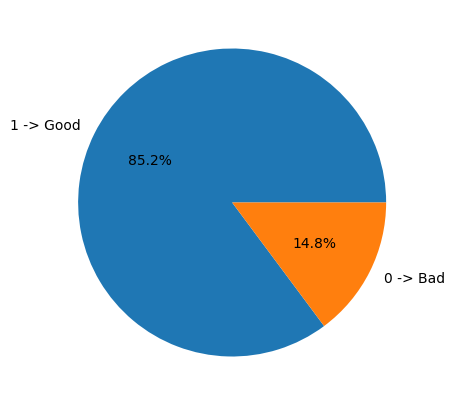

In [5]:
plt.figure(figsize=(5, 5))
plt.pie(temp, labels=['1 -> Good', '0 -> Bad'], autopct='%1.1f%%')
plt.show()

In [37]:
plt.savefig("pie_chart.png")

<Figure size 640x480 with 0 Axes>